# LSTM Ten-year Italy yield

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from tqdm import tqdm
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import LSTM,Conv2D,Flatten,Lambda,Multiply
from tensorflow.keras.layers import Dense,Dropout,Reshape,Dot,Concatenate
import copy

In [56]:
daily_data = pd.read_csv("Rendimenti_italia_giornaliero.csv",header=None,sep=";")
weekly_data = pd.read_csv("Rendimenti_italia.csv",header=None,sep=";")

In [57]:
weekly_data=weekly_data[::-1]
weekly_data.columns=['Data','Close','Open','High','Low','Variation']
weekly_data.head()

,Data,Close,Open,High,Low,Variation
525,15.11.2009,"4,058","4,058","4,058","4,058","-0,78"
524,22.11.2009,"4,030","4,030","4,030","4,030","-0,69%"
523,29.11.2009,"3,991","3,991","3,991","3,991","-0,97%"
522,06.12.2009,"4,013","4,013","4,013","4,013","0,55%"
521,13.12.2009,"3,970","3,970","3,970","3,970","-1,07%"


In [58]:
fig = go.Figure(data=[go.Candlestick(x=weekly_data['Data'],
                open=weekly_data['Open'], high=weekly_data['High'],
                low=weekly_data['Low'], close=weekly_data['Close'])])
fig.update_layout(
    title='Ten-year Italy yield',
    yaxis_title='',
    width=768)
fig.show()

In [59]:
daily_data=daily_data[::-1]
daily_data.columns=['Data','Close','Open','High','Low','Variation']
daily_data.head()

,Data,Close,Open,High,Low,Variation
2897,27.11.2009,"4,030","4,030","4,030","4,030","-0,57%"
2896,30.11.2009,"4,029","4,029","4,029","4,029","-0,02%"
2895,01.12.2009,"3,982","3,982","3,982","3,982","-1,17%"
2894,02.12.2009,"3,976","3,976","3,976","3,976","-0,15%"
2893,03.12.2009,"3,988","3,988","3,988","3,988","0,30%"


In [60]:
Months=np.zeros((len(daily_data['Close']),5))
labels=['Close','Open','High','Low']
for i in tqdm(range(len(daily_data['Close'])-1)):
    k=0
    for j in labels:
        value=float(daily_data[j][len(daily_data[j])-1-i][0])
        value2=float(daily_data[j][len(daily_data[j])-1-i][2:])
        Months[i,k]=value+value2/1000
        k+=1
    l=0
    while daily_data['Variation'][len(daily_data['Variation'])-1-i][l]!=',':
        l+=1
    if daily_data['Variation'][len(daily_data['Variation'])-1-i][0]=='-':
        number1=float(daily_data['Variation'][len(daily_data['Variation'])-1-i][1:l])
    else:
        number1=float(daily_data['Variation'][len(daily_data['Variation'])-1-i][0:l])
    number2=float(daily_data['Variation'][len(daily_data['Variation'])-1-i][l+1:-1])
    Months[i,k]=number1+number2/100
    

100%|████████████████████████████████████████████████████████████████████████████| 2897/2897 [00:00<00:00, 3416.39it/s]


In [61]:
chosen=30#number of days in the history
horizon=5
X_train=np.zeros((len(daily_data['Close'])-chosen-365,chosen,4))
Y_train=np.zeros((len(daily_data['Close'])-chosen-365,1))
X_val=np.zeros((365,chosen,4))
Y_val=np.zeros((365,1))
z=0
print ("Creation of the training data:\n")
for i in tqdm(range(len(daily_data['Close'])-chosen-365-horizon)):
    for j in range(chosen):
        X_train[z,j,0]=Months[i+j,0]
        X_train[z,j,1]=Months[i+j,1]
        X_train[z,j,2]=Months[i+j,2]
        X_train[z,j,3]=Months[i+j,3]
        #X_train[z,j,4]=Months[i+j,4]
    candidates1 = []
    for k in range(horizon):
        candidates1.append(Months[i+chosen+k,2])

    candidates2 = []
    for k in range(horizon):
        candidates2.append(Months[i+chosen+k,3])
    Y_train[z,0]=np.mean([np.mean(candidates1),np.mean(candidates2)])
    z+=1
z=0
print ("Creation of the validation data:\n")
for i in tqdm(range(365)):
    for j in range(chosen):
        X_val[z,j,0]=Months[i+j+len(daily_data['Close'])-chosen-365-horizon,0]
        X_val[z,j,1]=Months[i+j+len(daily_data['Close'])-chosen-365-horizon,1]
        X_val[z,j,2]=Months[i+j+len(daily_data['Close'])-chosen-365-horizon,2]
        X_val[z,j,3]=Months[i+j+len(daily_data['Close'])-chosen-365-horizon,3]
        #X_val[z,j,4]=Months[i+j+len(daily_data['Close'])-chosen-365-horizon,4]
    candidates1 = []
    for k in range(horizon):
        candidates1.append(Months[i+len(daily_data['Close'])-365-horizon+k,2])

    candidates2 = []
    for k in range(horizon):
        candidates2.append(Months[i+len(daily_data['Close'])-365-horizon+k,3])
    Y_val[z,0]=np.mean([np.mean(candidates1),np.mean(candidates2)])
    z+=1

Creation of the training data:



100%|████████████████████████████████████████████████████████████████████████████| 2498/2498 [00:00<00:00, 7857.86it/s]


Creation of the validation data:



100%|██████████████████████████████████████████████████████████████████████████████| 365/365 [00:00<00:00, 1383.01it/s]


# LSTM

In [62]:
from keras_tqdm import TQDMNotebookCallback
#del model
chosen=30
X_train=X_train.reshape((X_train.shape[0],X_train.shape[1],X_train.shape[2]))
X_train1=X_train[:,:,0]
X_train1=X_train1.reshape((X_train1.shape[0],X_train1.shape[1],1))
X_train2=X_train[:,:,1]
X_train2=X_train1.reshape((X_train2.shape[0],X_train2.shape[1],1))
X_train3=X_train[:,:,2]
X_train3=X_train3.reshape((X_train3.shape[0],X_train3.shape[1],1))
X_train4=X_train[:,:,3]
X_train4=X_train4.reshape((X_train4.shape[0],X_train4.shape[1],1))
X_val=X_val.reshape((X_val.shape[0],X_val.shape[1],X_val.shape[2]))
X_val1=X_val[:,:,0]
X_val1=X_val1.reshape((X_val1.shape[0],X_val1.shape[1],1))
X_val2=X_val[:,:,1]
X_val2=X_val2.reshape((X_val2.shape[0],X_val2.shape[1],1))
X_val3=X_val[:,:,0]
X_val3=X_val3.reshape((X_val3.shape[0],X_val3.shape[1],1))
X_val4=X_val[:,:,0]
X_val4=X_val4.reshape((X_val4.shape[0],X_val4.shape[1],1))
print (X_train1.shape)
print (X_train2.shape)
print (X_train3.shape)
print (X_train4.shape)
print (X_val.shape)
print (Y_train.shape)
print (Y_val.shape)

(2503, 30, 1)
(2503, 30, 1)
(2503, 30, 1)
(2503, 30, 1)
(365, 30, 4)
(2503, 1)
(365, 1)


In [12]:
from kerastuner.tuners import RandomSearch
import tensorflow as tf
def create_model():
    x1 = tf.keras.Input(shape=(30,1))
    x2 = tf.keras.Input(shape=(30,1))
    x3 = tf.keras.Input(shape=(30,1))
    x4 = tf.keras.Input(shape=(30,1))
    
    x11 = tf.keras.backend.squeeze(x1,axis=2)
    x21 = tf.keras.backend.squeeze(x2,axis=2)
    x31 = tf.keras.backend.squeeze(x3,axis=2)
    x41 = tf.keras.backend.squeeze(x4,axis=2)
            
    y1 = (Dense(30,activation='softmax'))(x11)
    y2 = (Dense(30,activation='softmax'))(x21)
    y3 = (Dense(30,activation='softmax'))(x31)
    y4 = (Dense(30,activation='softmax'))(x41)
    
    y11 = Multiply()([y1,x11])
    y21 = Multiply()([y2,x21])
    y31 = Multiply()([y3,x31])
    y41 = Multiply()([y4,x41])
        
    Conc = Concatenate(axis=1)([y11,y21,y31,y41])
    Conc = Reshape((30,4))(Conc)
    
    z2 = LSTM(30,activation='relu')(Conc)
    z2 = Dense(1)(z2)
    model = Model(inputs=[x1,x2,x3,x4],outputs=z2)
    model.compile(optimizer='adam', loss='mse',metrics=['accuracy'])
    return model

In [63]:
del best_model
best_model=create_model()
history=best_model.fit([X_train1,X_train2,X_train3,X_train4],
                  Y_train,epochs=40,verbose=0,batch_size=32,callbacks=[TQDMNotebookCallback()]
                  ,shuffle=True,validation_data=([X_val1,X_val2,X_val3,X_val4],Y_val))

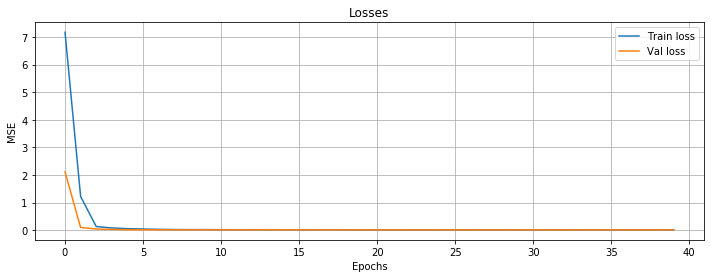

In [14]:
plt.figure(figsize=(12,4))
epochs=np.arange(40)
plt.plot(epochs,history.history['loss'],label='Train loss')
plt.plot(epochs,history.history['val_loss'],label='Val loss')
plt.grid()
plt.title('Losses')
plt.ylabel('MSE')
plt.xlabel('Epochs')
plt.legend()
plt.show()

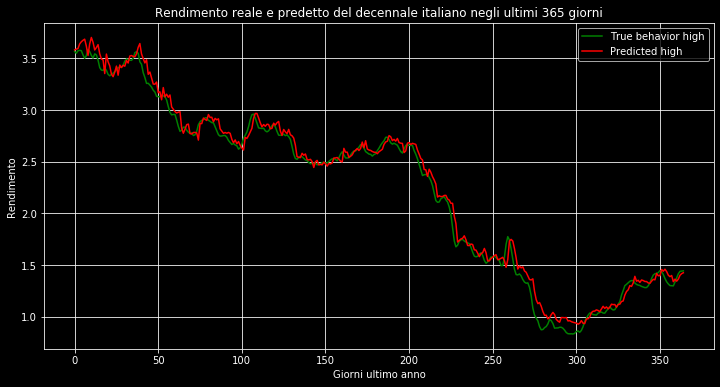

In [21]:
plt.style.use('dark_background')
plt.figure(figsize=(12,6))
days=np.arange(365)
plt.plot(days,Y_val[:,0],label='True behavior high',color='green')
plt.plot(days,best_model.predict([X_val1,X_val2,X_val3,X_val4]),label='Predicted',color='red')
plt.grid()
plt.title('Rendimento reale e predetto del decennale italiano negli ultimi 365 giorni')
plt.ylabel('Rendimento')
plt.xlabel('Giorni ultimo anno')
plt.legend()
plt.savefig('Predizione_2_giorni.pdf')
plt.show()

In [32]:

daily_data = pd.read_csv("Last.csv",header=None)
daily_data.columns=['Data','Close','Open','High','Low']
daily_data.head()

,Data,Close,Open,High,Low
0,25.35.40,"0,98","0,956","1,017","0,956"
1,24.35.40,"0,968","0,977","1,002","0,928"
2,22.35.40,"0,91","0,91","0,91","0,91"
3,21.35.40,"0,907","0,893","0,917","0,891"
4,20.35.40,"0,913","0,937","0,948","0,89"


In [39]:
LM = np.zeros((30,4))
MEAN = []
for i in range(30):
    LM[i,0]=float(daily_data['Close'][29-i][0]+'.'+daily_data['Close'][29-i][2:])
    LM[i,1]=float(daily_data['Open'][29-i][0]+'.'+daily_data['Open'][29-i][2:])
    LM[i,2]=float(daily_data['High'][29-i][0]+'.'+daily_data['High'][29-i][2:])
    LM[i,3]=float(daily_data['Low'][29-i][0]+'.'+daily_data['Low'][29-i][2:])
    MEAN.append(np.mean([LM[i,2],LM[i,3]]))

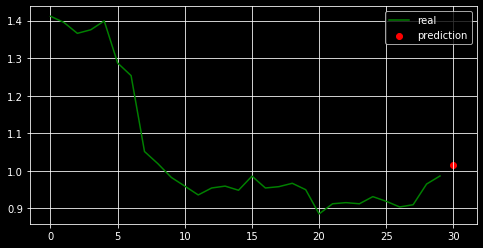

In [51]:
#model.load_weights('Prediction.h5')

plt.figure(figsize=(8,4))
plt.plot(MEAN,color='green',label='real')
plt.scatter([30],best_model.predict([LM[:,0].reshape(1,30,1),LM[:,1].reshape(1,30,1),
                            LM[:,2].reshape(1,30,1),LM[:,3].reshape(1,30,1)]),label='prediction',
           color='red')
plt.legend()
plt.grid()
plt.savefig('Prediction.pdf')
plt.show()